In [20]:
!pip install quantecon

     |████████████████████████████████| 179 kB 8.2 MB/s eta 0:00:01


In [129]:
import numpy as np
from scipy.stats import norm
from math import erfc, sqrt
from quantecon import MarkovChain
import quantecon as qe

from numba import njit

# 1. Discretize the State Space using Tauchen(1985)

In [130]:
"""
Filename: tauchen.py

Authors: Thomas Sargent, John Stachurski

Discretizes Gaussian linear AR(1) processes via Tauchen's method

"""


# [docs]
def approx_markov(rho, sigma_u, m = 3, n = 7):
    """
    Computes the Markov matrix associated with a discretized version of
    the linear Gaussian AR(1) process

        y_{t+1} = rho * y_t + u_{t+1}

    according to Tauchen's method.  Here {u_t} is an iid Gaussian
    process with zero mean.

    Parameters
    ----------
    rho : scalar(float)
        The autocorrelation coefficient
    sigma_u : scalar(float)
        The standard deviation of the random process
    m : scalar(int), optional(default=3)
        The number of standard deviations to approximate out to
    n : scalar(int), optional(default=7)
        The number of states to use in the approximation

    Returns
    -------

    x : array_like(float, ndim=1)
        The state space of the discretized process
    P : array_like(float, ndim=2)
        The Markov transition matrix where P[i, j] is the probability
        of transitioning from x[i] to x[j]

    """
    F = norm(loc=0, scale=sigma_u).cdf

    # standard deviation of y_t
    std_y = np.sqrt(sigma_u**2 / (1-rho**2))

    # top of discrete state space
    x_max = m * std_y

    # bottom of discrete state space
    x_min = - x_max

    # discretized state space
    x = np.linspace(x_min, x_max, n)

    step = (x_max - x_min) / (n - 1)
    half_step = 0.5 * step
    P = np.empty((n, n))

    for i in range(n):
        P[i, 0] = F(x[0] - rho * x[i] + half_step)
        P[i, n-1] = 1 - F(x[n-1] - rho * x[i] - half_step)
        for j in range(1, n-1):
            z = x[j] - rho * x[i]
            P[i, j] = F(z + half_step) - F(z - half_step)

    return x, P

## ( 1 ) If n = 2

In [131]:
x = approx_markov(rho = 0.95, sigma_u = 0.007, m = 3, n = 2)[0]
P = approx_markov(rho = 0.95, sigma_u = 0.007, m = 3, n = 2)[1]
x = np.round(x, decimals = 4)
P = np.round(P, decimals = 4)

print("Z is", x, "\nΠ is \n", P)

Z is [-0.0673  0.0673] 
Π is 
 [[1. 0.]
 [0. 1.]]


## ( 2 ) if n = 7

In [31]:
x = approx_markov(rho = 0.95, sigma_u = 0.007, m = 3, n = 7)[0]
P = approx_markov(rho = 0.95, sigma_u = 0.007, m = 3, n = 7)[1]

z_proc = np.round(x, decimals = 4)
Π_proc = np.round(P, decimals = 4)

print("Z is\n", z, "\nΠ is \n", Π)

Z is
 [-0.0673 -0.0448 -0.0224  0.      0.0224  0.0448  0.0673] 
Π is 
 [[0.8688 0.1312 0.     0.     0.     0.     0.    ]
 [0.0273 0.8726 0.1001 0.     0.     0.     0.    ]
 [0.     0.0391 0.8861 0.0748 0.     0.     0.    ]
 [0.     0.     0.0547 0.8907 0.0547 0.     0.    ]
 [0.     0.     0.     0.0748 0.8861 0.0391 0.    ]
 [0.     0.     0.     0.     0.1001 0.8726 0.0273]
 [0.     0.     0.     0.     0.     0.1312 0.8688]]


# ( 3 ) Discretize the State Space using Rouwenhorst method

In [168]:
#[docs]
def rouwenhorst(n, ybar, sigma, rho):
    r"""
    Takes as inputs n, p, q, psi. It will then construct a markov chain
    that estimates an AR(1) process of:
    :math:`y_t = \bar{y} + \rho y_{t-1} + \varepsilon_t`
    where :math:`\varepsilon_t` is i.i.d. normal of mean 0, std dev of sigma

    The Rouwenhorst approximation uses the following recursive defintion
    for approximating a distribution:

    .. math::

        \theta_2 =
        \begin{bmatrix}
        p     &  1 - p \\
        1 - q &  q     \\
        \end{bmatrix}

    .. math::

        \theta_{n+1} =
        p
        \begin{bmatrix}
        \theta_n & 0   \\
        0        & 0   \\
        \end{bmatrix}
        + (1 - p)
        \begin{bmatrix}
        0  & \theta_n  \\
        0  &  0        \\
        \end{bmatrix}
        + q
        \begin{bmatrix}
        0        & 0   \\
        \theta_n & 0   \\
        \end{bmatrix}
        + (1 - q)
        \begin{bmatrix}
        0  &  0        \\
        0  & \theta_n  \\
        \end{bmatrix}


    Parameters
    ----------
    n : int
        The number of points to approximate the distribution

    ybar : float
        The value :math:`\bar{y}` in the process.  Note that the mean of this
        AR(1) process, :math:`y`, is simply :math:`\bar{y}/(1 - \rho)`

    sigma : float
        The value of the standard deviation of the :math:`\varepsilon` process

    rho : float
        By default this will be 0, but if you are approximating an AR(1)
        process then this is the autocorrelation across periods

    Returns
    -------

    mc : MarkovChain
        An instance of the MarkovChain class that stores the transition
        matrix and state values returned by the discretization method

    """

    # Get the standard deviation of y
    y_sd = sqrt(sigma**2 / (1 - rho**2))

    # Given the moments of our process we can find the right values
    # for p, q, psi because there are analytical solutions as shown in
    # Gianluca Violante's notes on computational methods
    p = (1 + rho) / 2
    q = p
    psi = y_sd * np.sqrt(n - 1)

    # Find the states
    ubar = psi
    lbar = -ubar

    x = np.linspace(lbar, ubar, n)

    def row_build_mat(n, p, q):
        """
        This method uses the values of p and q to build the transition
        matrix for the rouwenhorst method

        """

        if n == 2:
            theta = np.array([[p, 1 - p], [1 - q, q]])

        elif n > 2:
            p1 = np.zeros((n, n))
            p2 = np.zeros((n, n))
            p3 = np.zeros((n, n))
            p4 = np.zeros((n, n))

            new_mat = row_build_mat(n - 1, p, q)

            p1[:n - 1, :n - 1] = p * new_mat
            p2[:n - 1, 1:] = (1 - p) * new_mat
            p3[1:, :-1] = (1 - q) * new_mat
            p4[1:, 1:] = q * new_mat

            theta = p1 + p2 + p3 + p4
            theta[1:n - 1, :] = theta[1:n - 1, :] / 2

        else:
            raise ValueError("The number of states must be positive " +
                             "and greater than or equal to 2")

        return theta

    theta = row_build_mat(n, p, q)

    x += ybar / (1 - rho)

    return x, MarkovChain(theta, x)


In [172]:
# i) n = 2

x = rouwenhorst(n = 2, ybar = 0 , sigma = 0.007, rho = .95)[0]
P = rouwenhorst(n = 2, ybar = 0 , sigma = 0.007, rho = .95)[1]



print("Z is", x, P)

Z is [-0.02241794  0.02241794] <bound method MarkovChain.__repr__ of Markov chain with transition matrix 
P = 
[[0.975 0.025]
 [0.025 0.975]]>


In [134]:
# ii) n = 7

x = rouwenhorst(n = 7, ybar = 0 , sigma = 0.007, rho = .95)[0]
P = rouwenhorst(n = 7, ybar = 0 , sigma = 0.007, rho = .95)[1]


print("Z is", x, P)

Z is [-5.49125178e-02 -3.66083452e-02 -1.83041726e-02  6.93889390e-18
  1.83041726e-02  3.66083452e-02  5.49125178e-02] <bound method MarkovChain.__repr__ of Markov chain with transition matrix 
P = 
[[8.59068301e-01 1.32164354e-01 8.47207397e-03 2.89643555e-04
  5.57006836e-06 5.71289063e-08 2.44140625e-10]
 [2.20273923e-02 8.61892326e-01 1.10281783e-01 5.65176270e-03
  1.44869385e-04 1.85693359e-06 9.52148438e-09]
 [5.64804932e-04 4.41127134e-02 8.63588969e-01 8.82833936e-02
  3.39180054e-03 5.79477539e-05 3.71337891e-07]
 [1.44821777e-05 1.69552881e-03 6.62125452e-02 8.64154888e-01
  6.62125452e-02 1.69552881e-03 1.44821777e-05]
 [3.71337891e-07 5.79477539e-05 3.39180054e-03 8.82833936e-02
  8.63588969e-01 4.41127134e-02 5.64804932e-04]
 [9.52148438e-09 1.85693359e-06 1.44869385e-04 5.65176270e-03
  1.10281783e-01 8.61892326e-01 2.20273923e-02]
 [2.44140625e-10 5.71289063e-08 5.57006836e-06 2.89643555e-04
  8.47207397e-03 1.32164354e-01 8.59068301e-01]]>


In [182]:
x = np.round(np.array([-5.49125178e-02, -3.66083452e-02, -1.83041726e-02,  6.93889390e-18]), decimals = 4)
P = np.round(np.array([[8.59068301e-01, 1.32164354e-01, 8.47207397e-03, 2.89643555e-04,
  5.57006836e-06, 5.71289063e-08, 2.44140625e-10],
                       [2.20273923e-02, 8.61892326e-01, 1.10281783e-01, 5.65176270e-03,
  1.44869385e-04, 1.85693359e-06, 9.52148438e-09], [5.64804932e-04, 4.41127134e-02, 8.63588969e-01, 8.82833936e-02,
  3.39180054e-03, 5.79477539e-05, 3.71337891e-07], [1.44821777e-05, 1.69552881e-03, 6.62125452e-02, 8.64154888e-01,
  6.62125452e-02, 1.69552881e-03, 1.44821777e-05], [3.71337891e-07, 5.79477539e-05, 3.39180054e-03, 8.82833936e-02,
  8.63588969e-01, 4.41127134e-02, 5.64804932e-04], [9.52148438e-09, 1.85693359e-06, 1.44869385e-04, 5.65176270e-03,
  1.10281783e-01, 8.61892326e-01, 2.20273923e-02], [2.44140625e-10, 5.71289063e-08, 5.57006836e-06, 2.89643555e-04,
  8.47207397e-03, 1.32164354e-01, 8.59068301e-01]] ), decimals = 4)
x, P

(array([-0.0549, -0.0366, -0.0183,  0.    ]),
 array([[8.591e-01, 1.322e-01, 8.500e-03, 3.000e-04, 0.000e+00, 0.000e+00,
         0.000e+00],
        [2.200e-02, 8.619e-01, 1.103e-01, 5.700e-03, 1.000e-04, 0.000e+00,
         0.000e+00],
        [6.000e-04, 4.410e-02, 8.636e-01, 8.830e-02, 3.400e-03, 1.000e-04,
         0.000e+00],
        [0.000e+00, 1.700e-03, 6.620e-02, 8.642e-01, 6.620e-02, 1.700e-03,
         0.000e+00],
        [0.000e+00, 1.000e-04, 3.400e-03, 8.830e-02, 8.636e-01, 4.410e-02,
         6.000e-04],
        [0.000e+00, 0.000e+00, 1.000e-04, 5.700e-03, 1.103e-01, 8.619e-01,
         2.200e-02],
        [0.000e+00, 0.000e+00, 0.000e+00, 3.000e-04, 8.500e-03, 1.322e-01,
         8.591e-01]]))

# 2. Value Function Iteration with Aggregate Uncertainty

## Model: Standard RBC with Divisible Labor

In [188]:
from sympy.functions.elementary.exponential import exp
from sympy.functions.elementary.exponential import log
from sympy import Symbol
from sympy import solve
from scipy.optimize import fminbound
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

In [189]:
# Assigning Parameteres
β = 0.99; θ = 0.36; δ = 0.025; ρ=0.95; σ = 0.007

# Defining the basic functions
def u(c,l, μ):
    return log(c) + μ * log(l)

def f(k, h, θ = θ):
    return (k**θ) * (h**(1-θ))

def c(z, k, kp,h, θ = θ):
    return exp(z)*f(k, h) + (1-δ)*k - kp

In [190]:
k = Symbol('k') ; z = Symbol('z'); h = Symbol('h'); kp = Symbol('kp')

# Setting the Steady State Level

z_bar = 0; h_bar = 1/3


# Setting Euler Equations
EE1 = β * (exp(z_bar) * f(k,h).diff(k).subs({h:h_bar}) + 1 - δ ) -1
k_bar = float(solve(EE1, k)[0])

μ = Symbol('μ')
c_bar = c(z_bar, k_bar, h_bar, k_bar)

EE2 = (1 / c_bar) * exp(z_bar) * f(k, h).diff(h).subs({k:k_bar, h:h_bar}) - μ/(1-h_bar)
μ = float(solve(EE2, μ)[0])



In [191]:
# Defining the basic functions in the Steady State
def u(c,l, μ = μ):
    return log(c) + μ * log(l)

def f(k, h=h_bar, θ = θ):
    return (k**θ) * (h**(1-θ))

def c(z, k, kp, h=h_bar, θ=θ):
    return exp(z) * f(k,h) + (1-δ)*k - kp

In [192]:
# Defining Maximization Funcion V on interval [a,b]
def maximum(V,a,b):
    return float(V(fminbound(lambda x: -V(x),a,b)))

# Defining Minimization Funcion V on interval [a,b]
def minimum(V,a,b):
    return float(V(fminbound(lambda x: V(x),a,b)))

# Defining the Maximizer of Function V on interval [a,b]
def maximizer(V,a,b):
    return float(fminbound(lambda x: -V(x),a,b))

# Defining the Minimizer of function V on interval [a,b]
def minimizer(V,a,b):
    return float(fminbound(lambda x: V(x),a,b))

In [216]:
# Setting the grid of state vairable over which the function will be approximated
grid_min = k_bar * 0.9
grid_max = f(k_bar) + (1-δ) * k_bar
grid_size = 30
grid = np.linspace(grid_min, grid_max, grid_size)

In [217]:
# The Shock Process follows Tauchen Method from #1
zs = z_proc 
Π = Π

# Gusse the initial Value Function
Vs = []
for i in range(np.size(zs)):
    Vs.append(interp1d(grid, np.log(grid)))

In [218]:
# Convergence in Value Function

max_iter = 1000
count = 0
tol = 1e-3

while count < max_iter:
    for i in range(np.size(zs)):
        if i == np.size(zs) - 1:
 
            vals = []
            z = zs[i]
            for k in grid:
                k_max = min(np.exp(z) * f(k) + (1-δ) * k, grid_max)
                VF = lambda k_prime: np.log(np.exp(z) * f(k) + (1-δ) * k - k_prime) + μ * np.log(1 - h_bar) + β * ( Π[i,0]*Vs[0](k_prime) +Π[i,1]*Vs[1](k_prime) +Π[i,2]*Vs[2](k_prime) +Π[i,3]*Vs[3](k_prime) +Π[i,4]*Vs[4](k_prime) + Π[i,5]*Vs[5](k_prime)+ Π[i,6]*Vs[6](k_prime))
                vals.append(maximum(VF, grid_min, k_max))
            
            VFP = interp1d(grid, vals)
            err = np.max(np.abs(VFP(grid) - Vs[i](grid)))
            Vs[i] = VFP
            
            
        else:
            
            vals = []
            z = zs[i]
            for k in grid:
                k_max = min(np.exp(z) * f(k) + (1-δ) * k, grid_max)
                VF = lambda k_prime: np.log(np.exp(z) * f(k) + (1-δ) * k - k_prime) + μ * np.log(1 - h_bar) + β * ( Π[i,0]*Vs[0](k_prime) +Π[i,1]*Vs[1](k_prime) +Π[i,2]*Vs[2](k_prime) +Π[i,3]*Vs[3](k_prime) +Π[i,4]*Vs[4](k_prime) + Π[i,5]*Vs[5](k_prime)+ Π[i,6]*Vs[6](k_prime))
                vals.append(maximum(VF, grid_min, k_max))
                
            Vs[i] = interp1d(grid, vals)
            
    if err < tol:
        print('The Number of Iterations is', count)
        break
    
    if int(count)%50 == 0:
        print("count", count)
        print("err", err)

        
    count += 1
            

count 0
err 0.9234575087406323
count 50
err 0.08481532834611372
count 100
err 0.05288390739948845
count 150
err 0.031377624843671015
count 200
err 0.018468346232280552
count 250
err 0.010856136583027975
count 300
err 0.006380183802528805
count 350
err 0.0037495312257380675
count 400
err 0.002203527908173797
count 450
err 0.0012949702601581237
The Number of Iterations is 475


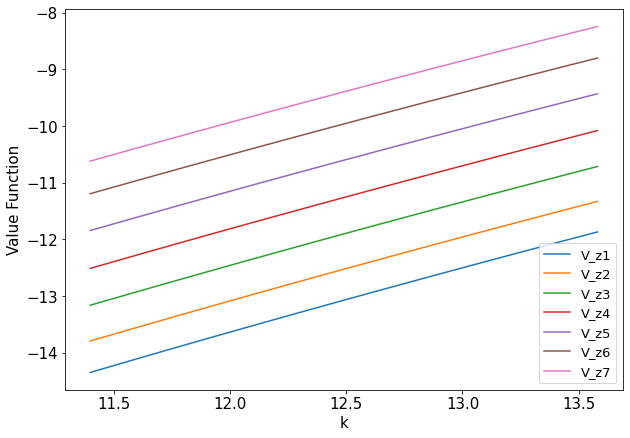

In [246]:
plt.figure(figsize=(10,7))
line1 = plt.plot(grid,Vs[0](grid),label = "V_z1")
plt.xlabel('k', fontsize = 15)
plt.ylabel('Value Function', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)
line2 = plt.plot(grid,Vs[1](grid),label = "V_z2")
line3 = plt.plot(grid,Vs[2](grid),label = "V_z3")
line4 = plt.plot(grid,Vs[3](grid),label = "V_z4")
line5 = plt.plot(grid,Vs[4](grid),label = "V_z5")
line6 = plt.plot(grid,Vs[5](grid),label = "V_z6")
line7 = plt.plot(grid,Vs[6](grid),label = "V_z7")
plt.legend(fontsize = 13)
plt.show()

In [232]:
# Policy Function

PFs = []

for i in range(np.size(Vs)):
    vals = []
    z = zs[i]
    
    for k in grid:
        k_max = min(np.exp(z) * f(k, h_bar) + (1 - δ) * k , grid_max)
        Vf = lambda k_prime: np.log(np.exp(z)*f(k,h_bar) + (1-δ)*k - k_prime) + μ * np.log(1 - h_bar) + β * ( Π[i,0]*Vs[0](k_prime) +Π[i,1]*Vs[1](k_prime) +Π[i,2]*Vs[2](k_prime) +Π[i,3]*Vs[3](k_prime) +Π[i,4]*Vs[4](k_prime) + Π[i,5]*Vs[5](k_prime)+ Π[i,6]*Vs[6](k_prime))
        vals.append(maximizer(Vf, grid_min, k_max))
    PFs.append(interp1d(grid, vals, kind = 'linear'))

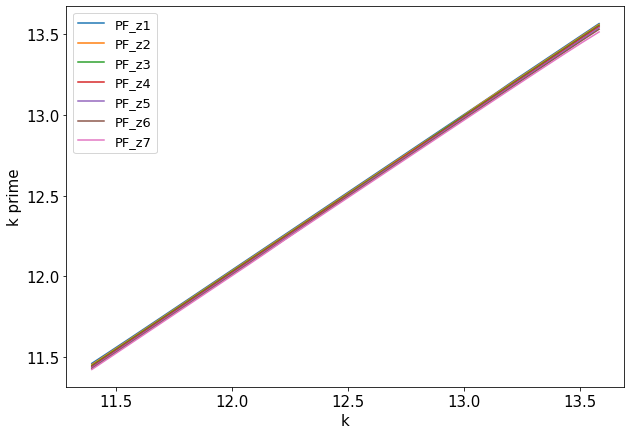

In [247]:
plt.figure(figsize=(10,7))

line1 = plt.plot(grid,PFs[0](grid),label = "PF_z1")
plt.xlabel('k', fontsize = 15)
plt.ylabel('k prime', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)
line2 = plt.plot(grid,PFs[1](grid),label = "PF_z2")
line3 = plt.plot(grid,PFs[2](grid),label = "PF_z3")
line4 = plt.plot(grid,PFs[3](grid),label = "PF_z4")
line5 = plt.plot(grid,PFs[4](grid),label = "PF_z5")
line6 = plt.plot(grid,PFs[5](grid),label = "PF_z6")
line7 = plt.plot(grid,PFs[6](grid),label = "PF_z7")

plt.legend(fontsize = 13)
plt.show()

## Drawing Impulse Response

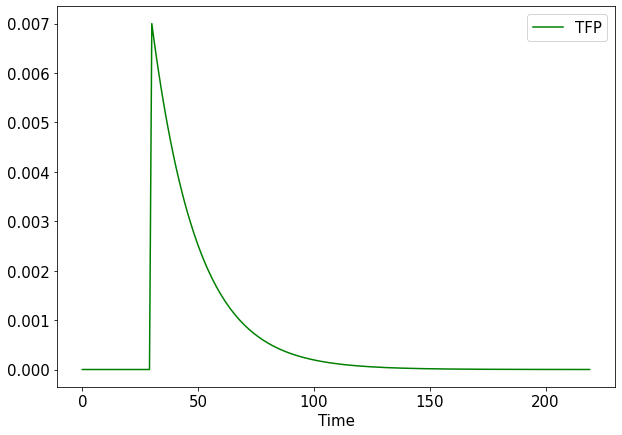

In [249]:
# Drawing Impulse Responses for the Variables

# TFP Shock's Impulse Response(Positive TFP Shock at t = 30)

z0 = z_bar
zs = []

t_min = 0
t_max = 220
time = np.linspace(t_min, t_max-1 , t_max - t_min)

for i in range(t_max):
    if i == 30:
        z1 = (1-ρ)*z_bar + ρ*z0 + σ
        zs.append(float(z1))
        z0 = z1
        
    else:
        z1 = (1-ρ)*z_bar + ρ*z0 
        zs.append(float(z1))
        z0 = z1
        
fig, ax = plt.subplots(figsize = (10,7))
ax.plot(time, zs , label = 'TFP', color = 'green')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time', fontsize = 15)
ax.legend(fontsize = 15)

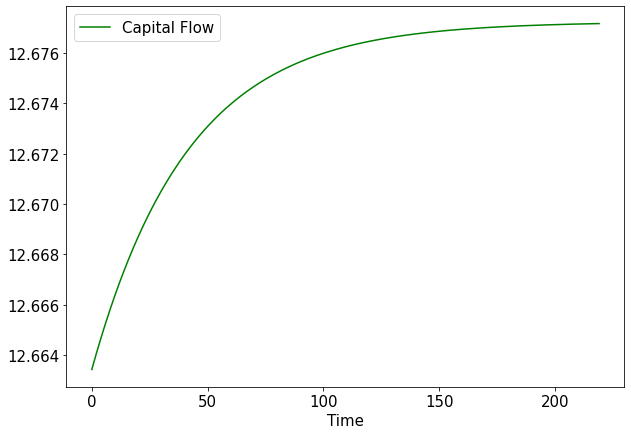

In [250]:
# Check the Capital's Steady State

ks = []
ks.append(k_bar)

for i in range(t_max):
    if zs[i] <= 0.5*(z_proc[0] + z_proc[1]):
        k1 = PFs[0](ks[i])
        ks.append(float(k1))
        
    if 0.5*(z_proc[0] + z_proc[1]) < zs[i] <= 0.5*(z_proc[1] + z_proc[2]):
        k1 = PFs[1](ks[i])
        ks.append(float(k1))
        
    if 0.5*(z_proc[1] + z_proc[2]) < zs[i] <= 0.5*(z_proc[2] + z_proc[3]):
        k1 = PFs[2](ks[i])
        ks.append(float(k1))
        
    if 0.5*(z_proc[2] + z_proc[3]) < zs[i] <= 0.5*(z_proc[3] + z_proc[4]):
        k1 = PFs[3](ks[i])
        ks.append(float(k1))
        
    if 0.5*(z_proc[3] + z_proc[4]) < zs[i] <= 0.5*(z_proc[4] + z_proc[5]):
        k1 = PFs[4](ks[i])
        ks.append(float(k1))
        
    if 0.5*(z_proc[4] + z_proc[5]) < zs[i] <= 0.5*(z_proc[5] + z_proc[6]):
        k1 = PFs[5](ks[i])
        ks.append(float(k1))
        
    if 0.5*(z_proc[5] + z_proc[6]) < zs[i]:
        k1.PFs[6](ks[i])
        ks.append(float(k1))
        
        
fig, ax = plt.subplots(figsize = (10,7))
ax.plot(ks[1:], label = 'Capital Flow', color = 'green')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time', fontsize = 15)
ax.legend(fontsize = 15)
plt.show()

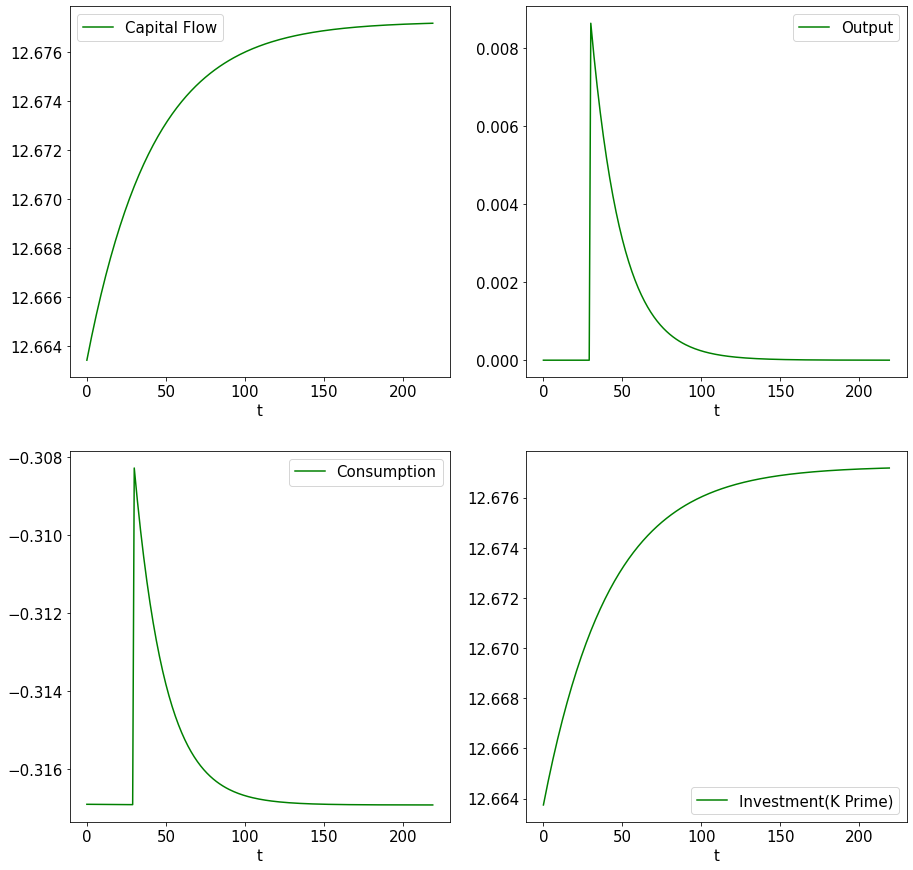

In [251]:
ys = []
ivs = []
cs = []

for i in range(t_max):
    y1 = zs[i] * f(ks[i+1])
    ys.append(y1)
    
    if zs[i] <= 0.5*(z_proc[0]+z_proc[1]) : 
        ivs1 = PFs[0](ks[i+1])
        ivs.append(float(ivs1))
        
    if 0.5*(z_proc[0]+z_proc[1]) < zs[i] <= 0.5*(z_proc[1]+z_proc[2]) :
        ivs1 = PFs[1](ks[i+1])
        ivs.append(float(ivs1))
        
    if 0.5*(z_proc[1]+z_proc[2]) < zs[i] <= 0.5*(z_proc[2]+z_proc[3]) :
        ivs1 = PFs[2](ks[i+1])
        ivs.append(float(ivs1))
        
    if 0.5*(z_proc[2]+z_proc[3]) < zs[i] <= 0.5*(z_proc[3]+z_proc[4]) :
        ivs1 = PFs[3](ks[i+1])
        ivs.append(float(ivs1))
    
    if 0.5*(z_proc[3]+z_proc[4]) < zs[i] <= 0.5*(z_proc[4]+z_proc[5]) :
        ivs1 = PFs[4](ks[i+1])
        ivs.append(float(ivs1))
    
    if 0.5*(z_proc[4]+z_proc[5]) < zs[i] <= 0.5*(z_proc[5]+z_proc[6]) :
        ivs1 = PFs[5](ks[i+1])
        ivs.append(float(ivs1))
    
    if 0.5*(z_proc[5]+z_proc[6]) < zs[i] :
        ivs1 = PFs[6](ks[i+1])
        ivs.append(float(ivs1))
        
    c1 = y1 + (1-δ) * ks[i+1] - ivs1
    cs.append(c1)
    
fig, ax = plt.subplots(2,2, figsize = (15, 15))
ax[0,0].plot(time, ks[1:], label = 'Capital Flow', color = 'green')
ax[0,0].legend(fontsize = 15)
ax[0,0].set_xlabel('t', fontsize = 15)
ax[0,0].tick_params(axis='both', which='major', labelsize=15)
ax[0,1].plot(time, ys, label = 'Output', color =  'green')
ax[0,1].legend(fontsize = 15)
ax[0,1].set_xlabel('t', fontsize = 15)
ax[0,1].tick_params(axis='both', which='major', labelsize=15)
ax[1,0].plot(time, cs, label = 'Consumption', color = 'green')
ax[1,0].legend(fontsize = 15)
ax[1,0].set_xlabel('t', fontsize = 15)
ax[1,0].tick_params(axis='both', which='major', labelsize=15)
ax[1,1].plot(time, ivs, label = 'Investment(K Prime)',color =  'green')
ax[1,1].legend(fontsize = 15)
ax[1,1].set_xlabel('t', fontsize = 15)
ax[1,1].tick_params(axis='both', which='major', labelsize=15)


## Simulation

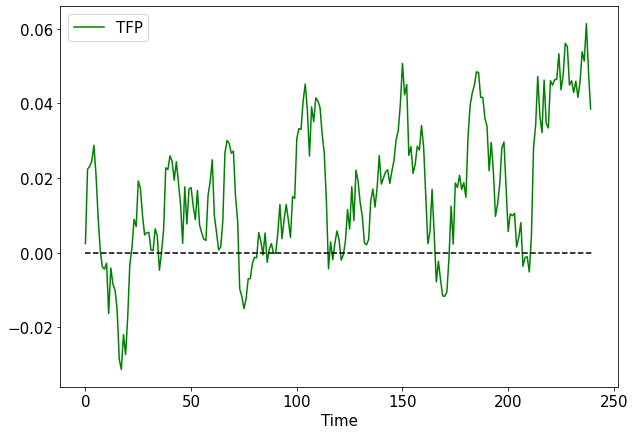

In [252]:
# Generate Random TFP sequence

t_min = 0; t_max = 240
time = np.linspace(t_min, t_max-1, t_max - t_min)

z0 = z_bar
zs = []

for i in range(t_max):
    z1 = ρ * z0 + σ * np.random.randn()
    zs.append(float(z1))
    z0 = z1
    
fig, ax = plt.subplots(figsize = (10,7))
ax.plot(time, zs, label = 'TFP', color = 'green')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time', fontsize = 15)
ax.legend(fontsize = 15)
ax.hlines(y = 0, xmin = 0, xmax = 240, color = 'k', linestyles = 'dashed')
plt.show()
    

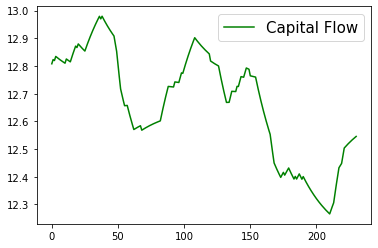

In [117]:
ys = []
ivs = []
cs = []
ks = []

ks.append(k_bar)

for i in range(t_max):
    if zs[i] <= 0.5*(z_proc[0] + z_proc[1]):
        k1 = PFs[0](ks[i])
        ks.append(float(k1))
        
    if 0.5*(z_proc[0] + z_proc[1]) < zs[i] <= 0.5*(z_proc[1] + z_proc[2]):
        k1 = PFs[1](ks[i])
        ks.append(float(k1))
        
    if 0.5*(z_proc[1] + z_proc[2]) < zs[i] <= 0.5*(z_proc[2] + z_proc[3]):
        k1 = PFs[2](ks[i])
        ks.append(float(k1))
        
    if 0.5*(z_proc[2] + z_proc[3]) < zs[i] <= 0.5*(z_proc[3] + z_proc[4]):
        k1 = PFs[3](ks[i])
        ks.append(float(k1))
        
    if 0.5*(z_proc[3] + z_proc[4]) < zs[i] <= 0.5*(z_proc[4] + z_proc[5]):
        k1 = PFs[4](ks[i])
        ks.append(float(k1))
        
    if 0.5*(z_proc[4] + z_proc[5]) < zs[i] <= 0.5*(z_proc[5] + z_proc[6]):
        k1 = PFs[5](ks[i])
        ks.append(float(k1))
        
    if 0.5*(z_proc[5] + z_proc[6]) < zs[i]:
        k1.PFs[6](ks[i])
        ks.append(float(k1))
        
                
fig, ax = plt.subplots()
ax.plot(ks[10:], label = 'Capital Flow', color = 'green')
ax.legend(fontsize = 15)
plt.show()

In [118]:
for i in range(t_max):
    k1 = ks[i]
    y1 = float(exp(zs[i]) * f(k1) )
    ys.append(y1)
    
    if zs[i] <= 0.5*(z_proc[0]+z_proc[1]) : 
        ivs1 = PFs[0](ks[i+1])
        ivs.append(float(ivs1))
        
    if 0.5*(z_proc[0]+z_proc[1]) < zs[i] <= 0.5*(z_proc[1]+z_proc[2]) :
        ivs1 = PFs[1](ks[i+1])
        ivs.append(float(ivs1))
        
    if 0.5*(z_proc[1]+z_proc[2]) < zs[i] <= 0.5*(z_proc[2]+z_proc[3]) :
        ivs1 = PFs[2](ks[i+1])
        ivs.append(float(ivs1))
        
    if 0.5*(z_proc[2]+z_proc[3]) < zs[i] <= 0.5*(z_proc[3]+z_proc[4]) :
        ivs1 = PFs[3](ks[i+1])
        ivs.append(float(ivs1))
    
    if 0.5*(z_proc[3]+z_proc[4]) < zs[i] <= 0.5*(z_proc[4]+z_proc[5]) :
        ivs1 = PFs[4](ks[i+1])
        ivs.append(float(ivs1))
    
    if 0.5*(z_proc[4]+z_proc[5]) < zs[i] <= 0.5*(z_proc[5]+z_proc[6]) :
        ivs1 = PFs[5](ks[i+1])
        ivs.append(float(ivs1))
    
    if 0.5*(z_proc[5]+z_proc[6]) < zs[i] :
        ivs1 = PFs[6](ks[i+1])
        ivs.append(float(ivs1))
        
    c1 = y1 + (1-δ) * k1 - ivs1
    cs.append(c1)

In [127]:
# Model Generated Standard Deviations from 100 Simulations

lnks_cycle = [] ; lnys_cycle = []; lnivs_cycle = []; lncs_cycle = []

for j in range(100):
    
    z0 = z_bar; zs = [];ys = []; ivs = []; cs = []; ks = []
    lnks = [] ; lnys = []; lnivs = []; lncs = []
    
    ks.append(k_bar)

    for i in range(t_max):
        z1 = ρ * z0 + σ * np.random.randn()
        zs.append(float(z1))
        z0 = z1


    for i in range(t_max):
        if zs[i] <= 0.5*(z_proc[0] + z_proc[1]):
            k1 = PFs[0](ks[i])
            ks.append(float(k1))
        
        if 0.5*(z_proc[0] + z_proc[1]) < zs[i] <= 0.5*(z_proc[1] + z_proc[2]):
            k1 = PFs[1](ks[i])
            ks.append(float(k1))
        
        if 0.5*(z_proc[1] + z_proc[2]) < zs[i] <= 0.5*(z_proc[2] + z_proc[3]):
            k1 = PFs[2](ks[i])
            ks.append(float(k1))
        
        if 0.5*(z_proc[2] + z_proc[3]) < zs[i] <= 0.5*(z_proc[3] + z_proc[4]):
            k1 = PFs[3](ks[i])
            ks.append(float(k1))
        
        if 0.5*(z_proc[3] + z_proc[4]) < zs[i] <= 0.5*(z_proc[4] + z_proc[5]):
            k1 = PFs[4](ks[i])
            ks.append(float(k1))
        
        if 0.5*(z_proc[4] + z_proc[5]) < zs[i] <= 0.5*(z_proc[5] + z_proc[6]):
            k1 = PFs[5](ks[i])
            ks.append(float(k1))
        
        if 0.5*(z_proc[5] + z_proc[6]) < zs[i]:
            k1 = PFs[6](ks[i])
            ks.append(float(k1))
            
    for i in range(t_max):
        k1 = ks[i]
        y1 = float(exp(zs[i]) * f(k1) )
        ys.append(y1)
    
        if zs[i] <= 0.5*(z_proc[0]+z_proc[1]) : 
            ivs1 = PFs[0](ks[i+1])
            ivs.append(float(ivs1))
        
        if 0.5*(z_proc[0]+z_proc[1]) < zs[i] <= 0.5*(z_proc[1]+z_proc[2]) :
            ivs1 = PFs[1](ks[i+1])
            ivs.append(float(ivs1))
        
        if 0.5*(z_proc[1]+z_proc[2]) < zs[i] <= 0.5*(z_proc[2]+z_proc[3]) :
            ivs1 = PFs[2](ks[i+1])
            ivs.append(float(ivs1))
        
        if 0.5*(z_proc[2]+z_proc[3]) < zs[i] <= 0.5*(z_proc[3]+z_proc[4]) :
            ivs1 = PFs[3](ks[i+1])
            ivs.append(float(ivs1))
    
        if 0.5*(z_proc[3]+z_proc[4]) < zs[i] <= 0.5*(z_proc[4]+z_proc[5]) :
            ivs1 = PFs[4](ks[i+1])
            ivs.append(float(ivs1))
    
        if 0.5*(z_proc[4]+z_proc[5]) < zs[i] <= 0.5*(z_proc[5]+z_proc[6]) :
            ivs1 = PFs[5](ks[i+1])
            ivs.append(float(ivs1))
        
        if 0.5*(z_proc[5]+z_proc[6]) < zs[i] :
            ivs1 = PFs[6](ks[i+1])
            ivs.append(float(ivs1))
        
        c1 = y1 + (1-δ) * k1 - ivs1
        cs.append(c1)
    
    for i in range(t_max):
        lnks.append(np.log(ks[i]))
        lnys.append(np.log(ys[i]))
        lncs.append(np.log(cs[i]))
        lnivs.append(np.log(ivs[i]))
        
    lndf = pd.DataFrame({'lnks':lnks,'lnys':lnys,'lncs':lncs,'lnivs':lnivs})
    
    cycle, trend = sm.tsa.filters.hpfilter(lndf.iloc[:,0],1600)
    lnks_cycle.append(cycle.std())
    
    cycle, trend = sm.tsa.filters.hpfilter(lndf.iloc[:,1],1600)
    lnys_cycle.append(cycle.std())
    
    cycle, trend = sm.tsa.filters.hpfilter(lndf.iloc[:,2],1600)
    lncs_cycle.append(cycle.std())
    
    cycle, trend = sm.tsa.filters.hpfilter(lndf.iloc[:,3],1600)
    lnivs_cycle.append(cycle.std())

In [254]:
# Calculating the model generated standard deviation

np.round(np.mean(lnks_cycle), decimals = 4), np.round(np.mean(lnys_cycle), decimals = 4),np.round(np.mean(lncs_cycle), decimals = 4), np.round(np.mean(lnivs_cycle), decimals = 4)

(0.0023, 0.0091, 0.0131, 0.0025)